# Hand written digits classifier

### Image classification is a hard task

Within the field of machine learning and pattern recognition, image classification (especially for handwritten text) is towards the difficult end of the spectrum. There are a few reasons for this.

   - First, each image in a training set is high dimensional. Each pixel in an image is a feature and a separate column. This means that a 128 x 128 image has 16384 features.
   - Second, images are often downsampled to lower resolutions and transformed to grayscale (no color). Information contained in the higher resolution pictures are often lost when they are downscaled. For example the resolution of a 8 megapixel photo has 3264 by 2448 pixels, resulting in a total of 7,990,272 features (around 8 million). When these images are scaled down to  between 128 and 512 pixels we get significantly faster processin at the cost of losign  detail which is valuable for training
   - Third, the features in an image don't have an obvious linear or nonlinear relationship that can be learned with a model like linear or logistic regression. In grayscale, each pixel is just represented as a brightness value ranging from 0 to 256
   
deep neural networks have been used to reach state-of-the-art performance on image classification tasks in the last decade. For some image classification tasks, deep neural networks actually perform as well as or slightly better than the human benchmark. You can read about the history of deep neural networks [here](https://arxiv.org/pdf/1803.01164.pdf).

Deep learning is effective in image classification because of the models' ability to learn hierarchical representations. At a high level, an effective deep learning model learns intermediate representations at each layer in the model and uses them in the prediction process. Here's a diagram that visualizes what the weights represent at each layer of a convolutional neural network, a type of network that's often used in image classification

<img src="https://github.com/renuka28/datascience/blob/master/Building_A_Handwritten_Digits_Classifier/nn_learns_hierarchy.png?raw=true" alt="weights represent at each layer of a convolutional neural network" title="weights represent at each layer of a convolutional neural network" />



## Objective 
In this project we will

   - try to understand why image classification is a difficult task
   - understand the limitations of traditional machine learning models for image classification
   - train, test, and improve a few different deep neural networks for image classification
   
### Load image data

[UCI hand written digits dataset](http://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits) is one of the pre-loaded datasets available from **`skelearn.datsets`**. We can use **`load_digits()`** function to retun a copy of the dataset

Each row in the dataframe contains a image. To visialize the image, we need to reshape the row into 28 by 28 image

Lets first load the data and visualize first few digits to get an idea how they look

In [1]:
from sklearn.model_selection import KFold
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_digits
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
def get_data_labels():
    digits_data = load_digits()
    print(digits_data.keys())

    data = pd.DataFrame(digits_data['data'])
    labels = pd.Series(digits_data['target'])
    return data, labels
    

In [3]:
data, labels = get_data_labels()
summary = {}
data.head(1)

dict_keys(['target_names', 'images', 'data', 'target', 'DESCR'])


,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,0.0,0.0,5.0,13.0,9.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,6.0,13.0,10.0,0.0,0.0,0.0


In [4]:
def plot_image(image, ax=None):
    np_image = image.values
    np_image = np_image.reshape(8,8)
    if ax ==None:
        plt.imshow(np_image, cmap='gray_r')
    else:
        ax.imshow(np_image, cmap='gray_r')
    

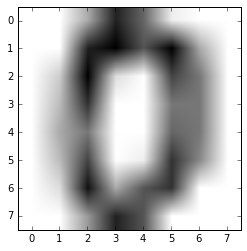

In [5]:
first_image = data.iloc[0]
plot_image(first_image)

In [6]:
def plot_random_digits(data):
    f, axarr = plt.subplots(2, 4)

    for i in range(2):
        for j in range(4):
            # plot some random digits to get an idea about how they look
            plot_image(data.iloc[np.random.randint(0, len(data))], axarr[i, j])
    plt.show()

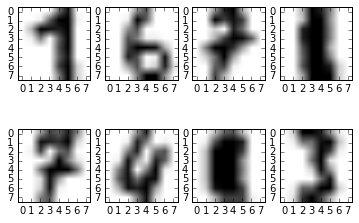

In [7]:
plot_random_digits(data)

## Fitting Machine learning models

We have multiple options to chose from. We can choose liner or logistic regression models or go with neural networks. Both linear and logistic regression models make assumption on the linearity between training features and the output lables/target columns. Other models like K-nearest models and neural networks makes no such assumptions. Since the data for our images are just values indicating the brightiness of a pixel there is not much linearty to be captured. We can try K-neaarest and neural models and hope they are able to do a good job

### K-Nearest Neighbors model (actually just an algorithm)

k-nearest neighbors don't have a specific model representation. The k-nearest algorithm works by comparing every unseen observation from test set or new inputs with all or many (depending on the implementation) training observation to pick the observation(s) which are similar to input. hen, the algorithm finds the label with the most nearby observations and assigns that as the prediction for the unseen observation.

KNeighborsClassifier package can be used to train and test k-nearest neighbors models.

We will setup functions for train, test and cross validating K-Nearest Neighbors models

In [8]:
def train(features, labels, nneighbors=1, neuron_arch=(1,), model_to_train="KNeighborsClassifier"):
    model = None
    if model_to_train == "MLPClassifier":
        model = MLPClassifier(hidden_layer_sizes=neuron_arch)
    elif model_to_train == "KNeighborsClassifier":
        model = KNeighborsClassifier(n_neighbors=nneighbors)
    model.fit(features, labels)
    return model


def test(model, features, labels):
    predictions = model.predict(features)
    train_test_df = pd.DataFrame()
    train_test_df['correct_label'] = labels
    train_test_df['predicted_label'] = predictions
    overall_accuracy = sum(
        train_test_df["predicted_label"] == train_test_df["correct_label"])/len(train_test_df)
    return overall_accuracy


def cross_validate(nneighbors=1, splits=4, neuron_arch=(1,), model_to_train="KNeighborsClassifier"):
    fold_accuracies = []
    kf = KFold(n_splits=splits, random_state=2, shuffle=True)
    for train_index, test_index in kf.split(data):
        train_features, test_features = data.loc[train_index], data.loc[test_index]
        train_labels, test_labels = labels.loc[train_index], labels.loc[test_index]
        model = train(train_features,
                      train_labels,
                      nneighbors=nneighbors,
                      neuron_arch=neuron_arch,
                      model_to_train=model_to_train)
        overall_accuracy = test(model, test_features, test_labels)
        fold_accuracies.append(overall_accuracy)
    return fold_accuracies

In [9]:
def print_best_worst_accuracy(accuracy_dict):
    best_worst = []
    worst_accuracy_at = min(accuracy_dict, key=accuracy_dict.get)
    worst_accuracy = accuracy_dict[worst_accuracy_at]
    best_worst.append(worst_accuracy_at)
    best_worst.append(worst_accuracy)

    best_accuracy_at = max(accuracy_dict, key=accuracy_dict.get)
    best_accuracy = accuracy_dict[best_accuracy_at]
    best_worst.append(best_accuracy_at)
    best_worst.append(best_accuracy)
    print("worst accuracy is {:0.4f} acheived at {}".format(
        worst_accuracy, worst_accuracy_at))
    print("best accuracy is {:0.4f} acheived at {}".format(
        best_accuracy, best_accuracy_at))
    return best_worst


def validate_and_plot_with_multiple_values(k_values=[1], k_splits=[4],
                                           neuron_arches=(1,),
                                           model_to_train="KNeighborsClassifier"):
     # if there are more than one k values, then show plot

    overall_accuracies = []
    accuracy_dict = {}
    loop_over_type = None
    loop_over = None
    k = None
    n_arch = None
    key = None
    index = 0

    # if it knn we loop over various k values else if it is nn we loop over various neuron counts
    if model_to_train == "KNeighborsClassifier":
        loop_over_type = "k values"
        loop_over = k_values
    elif model_to_train == "MLPClassifier":
        loop_over = neuron_arches
        loop_over_type = "nueron values"

    # if there are more than one set of values, then setup a figure to plot
    n_num_ax = len(k_splits)
    fig, axarr = plt.subplots(n_num_ax, 1)
    axis = axarr
    fig.set_size_inches(12, n_num_ax*8)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    print()
    print("#" * 80)
    print("testing `{}` with {} = {} and splits = {}...".format(
        model_to_train, loop_over_type,  loop_over, k_splits))

    for split in k_splits:
        k_accuracies = []

        for loop_var in loop_over:
            # lets assign the loop_var to appropriate parameter
            if model_to_train == "KNeighborsClassifier":
                k = loop_var
                n_arch = None
                key = "split = {} and k = {}".format(split, loop_var)
            elif model_to_train == "MLPClassifier":
                n_arch = loop_var
                k = None
                key = "split = {} and neurons = {}".format(split, loop_var)
            accuracies = cross_validate(nneighbors=k,
                                        neuron_arch=n_arch,
                                        splits=split,
                                        model_to_train=model_to_train)
            k_mean_accuracy = np.mean(accuracies)
            accuracy_dict[key] = k_mean_accuracy
            k_accuracies.append(k_mean_accuracy)

        # if there are more than one k values, then plot graph an new axis
        if n_num_ax > 1:
            axis = axarr[index]

        axis.plot(loop_over, k_accuracies)
        axis.set_title(
            "Mean Accuracy vs. k with split = {}. Min = {:0.4f}, Max = {:0.4f} and Mean = {:0.4f}".format(
                split, min(k_accuracies), max(k_accuracies), np.mean(k_accuracies)))
        index += 1
        overall_accuracies.append(k_accuracies)

    best_worst = print_best_worst_accuracy(accuracy_dict)
    # plt.show()

    return overall_accuracies, best_worst, accuracy_dict


def build_summary(summary):
    rows = []
    for key, items in summary.items():
        row = [key] +items
        rows.append(row)

    summary_df = pd.DataFrame(rows, columns=[
                              'model', 'worst_accuracy_at', 'worst_accuracy', 'best_accuracy_at', 'best_accuracy', 'mean accuracy'])
    return summary_df

## K-Nearest Neighbors model with one split and 6 k-values


################################################################################
testing `KNeighborsClassifier` with k values = [1, 2, 3, 4, 5, 6, 7, 8, 9] and splits = [4]...
worst accuracy is 0.9805 acheived at split = 4 and k = 8
best accuracy is 0.9889 acheived at split = 4 and k = 1
mean accuracy = 98.411202%


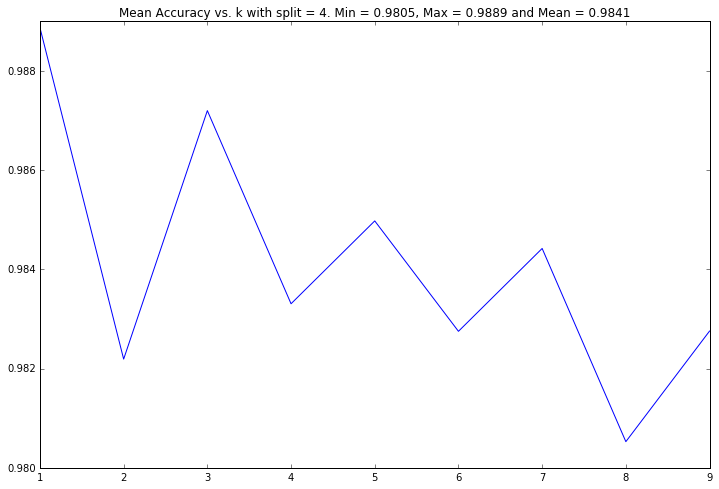

In [10]:
# test knn models
k_values = list(range(1, 10))

overall_accuracies, best_worst, accuracy_dict = validate_and_plot_with_multiple_values(k_values=k_values,
                                                                                       model_to_train="KNeighborsClassifier")
best_worst.append(np.mean(overall_accuracies)*100)
key = "KNeighborsClassifier with k = {}".format(k_values)
summary[key] = best_worst
print("mean accuracy = {:0.6f}%".format(best_worst[-1]))


We have close 97% accuracy in the first try itself, which is very good. We can now vary both nearest neighbors and also splits which defines data split between training and testing. We can get a good understanding of how the accuracy varies


## K-Nearest Neighbors model with 5 splits and 6 k-values



################################################################################
testing `KNeighborsClassifier` with k values = [1, 2, 3, 4, 5, 6, 7, 8, 9] and splits = [2, 4, 6, 8, 10]...
worst accuracy is 0.9711 acheived at split = 2 and k = 9
best accuracy is 0.9889 acheived at split = 4 and k = 1
mean accuracy = 98.277380%


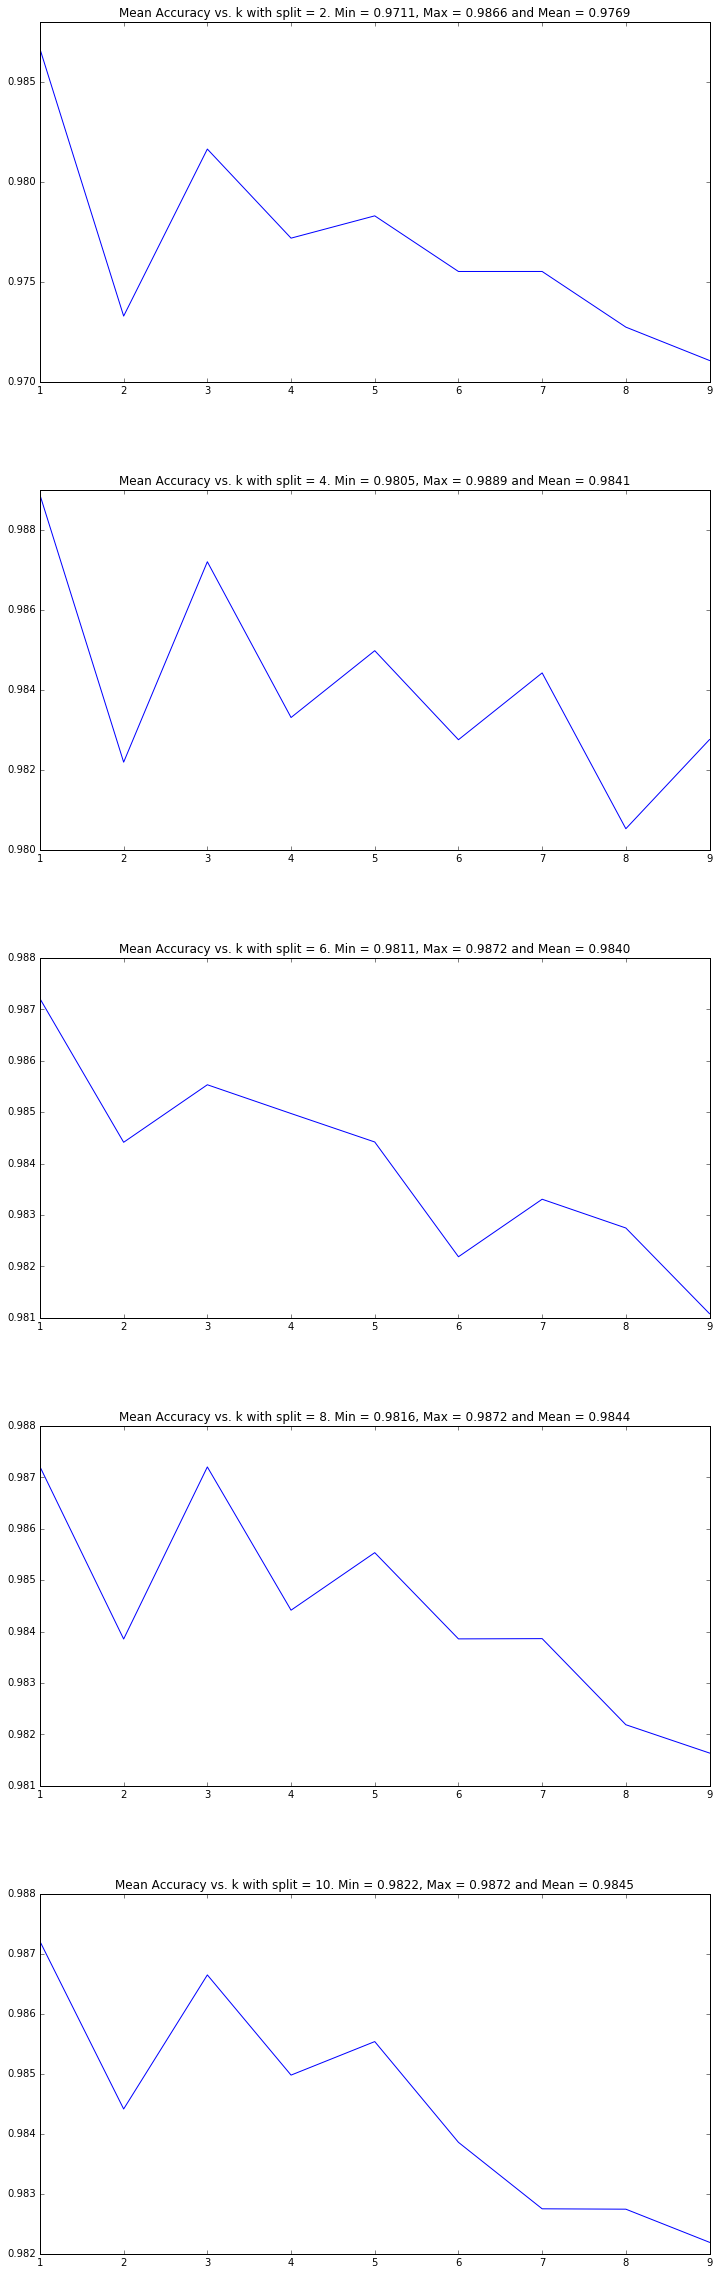

In [11]:
#test with more splits
splits = list(range(2, 12, 2))
overall_accuracies, best_worst, accuracy_dict = validate_and_plot_with_multiple_values(k_values=list(range(1, 10)),
                                                                                       k_splits=splits,
                                                                                       model_to_train="KNeighborsClassifier")
best_worst.append(np.mean(overall_accuracies)*100)
key = "KNeighborsClassifier with k = {} \nand splits = {}".format(
    k_values, splits)
summary[key] = best_worst
print("mean accuracy = {:0.6f}%".format(best_worst[-1]))

K-nearest neighbour has worked very well. It has a accuaracy ranging from 94% to 97% which is quite good. But there are few downsides to using this algorithm

  - high memory usage. For every new observation, many comparisons need to be made to seen observations. Although there are approaches where we limit the number of such comparisions, that comes at the cost of accuracy
  - no model representation to debug and explore
  

# Neural networks

Lets now work with neural networs and see if we can better the results. We tweaked both folds and k values in k-nearest neighbour to understand how the algorithm behaves under different conditions. We can do the same in neural by tweaking number of neurons and hidden layers. 

## Neural Network with single hidden layer with neurons ranging from 8 to 128

We will start with a single hidden layer neural network with 8, 16, 32, 64, 128 and 256 neurons in that layer

In [12]:
# one layer
nn_one_neurons = [(2**i, ) for i in range(3, 6)]
nn_one_neurons

[(8,), (16,), (32,)]


################################################################################
testing `MLPClassifier` with nueron values = [(8,), (16,), (32,)] and splits = [2, 4, 6, 8, 10]...


/dataquest/system/env/python3/lib/python3.4/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.



worst accuracy is 0.8576 acheived at split = 4 and neurons = (8,)
best accuracy is 0.9661 acheived at split = 10 and neurons = (32,)
mean accuracy = 93.322915%


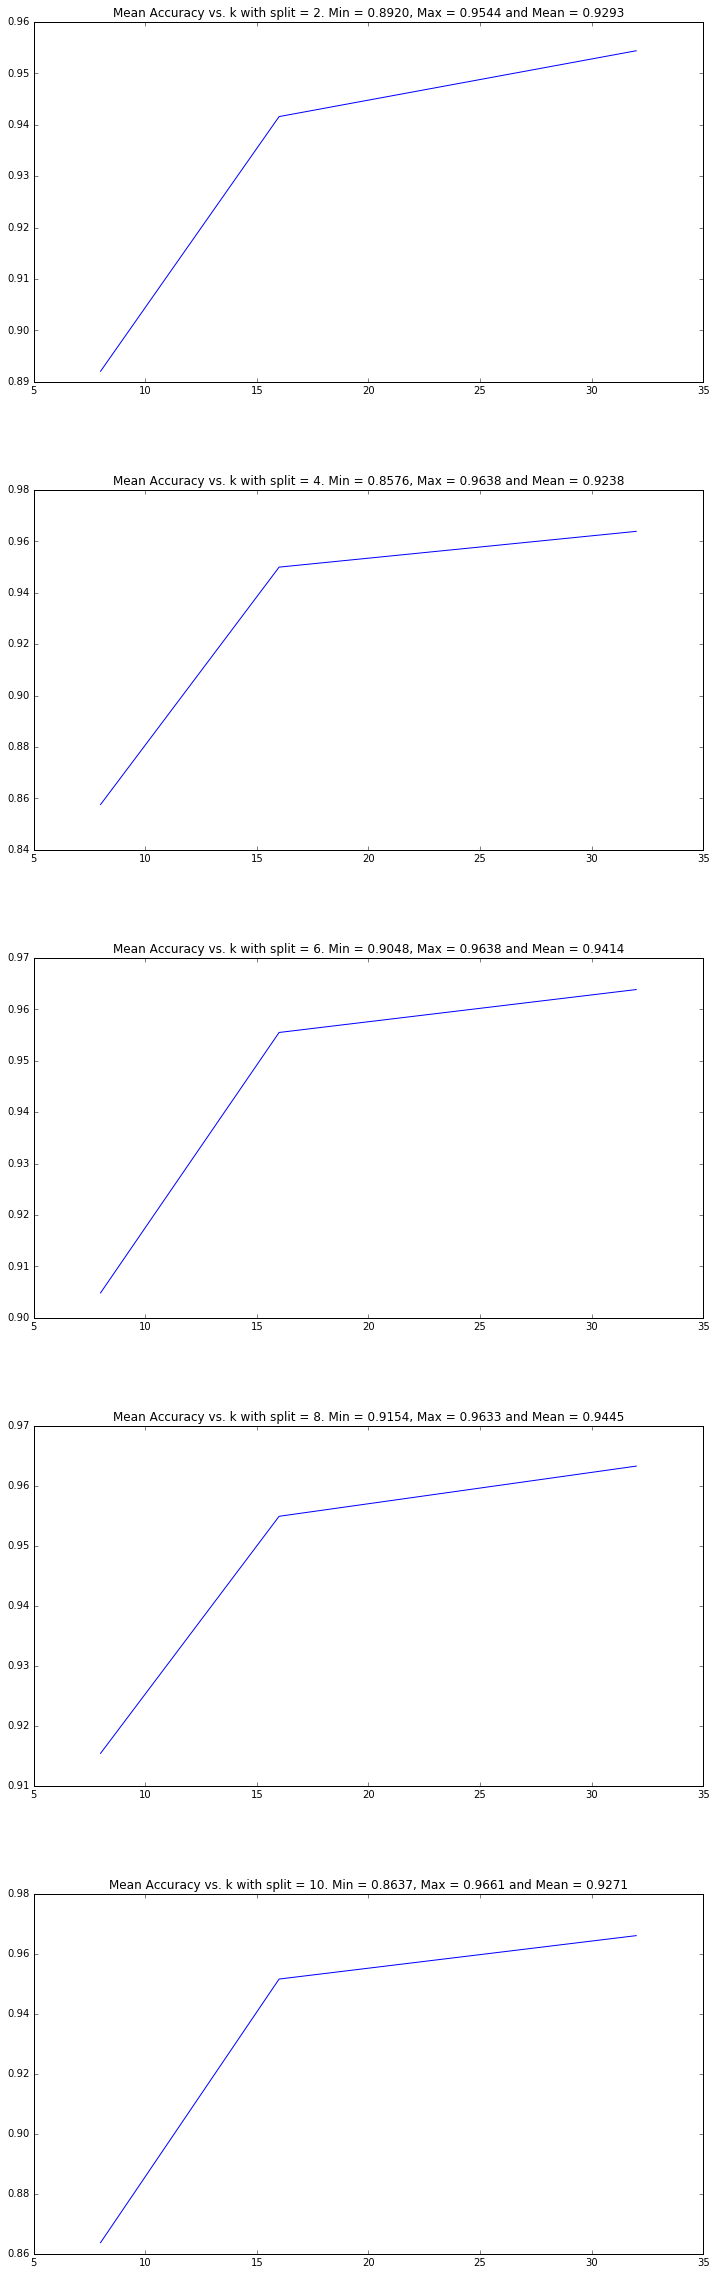

In [13]:
splits = list(range(2, 12, 2))
overall_accuracies, best_worst, accuracy_dict = validate_and_plot_with_multiple_values(neuron_arches=nn_one_neurons,
                                                                                       k_splits=splits,
                                                                                       model_to_train="MLPClassifier")
best_worst.append(np.mean(overall_accuracies)*100)
key = "MLPClassifier with neurons = {} \nand splits = {}".format(
    nn_one_neurons, splits)
summary[key] = best_worst
print("mean accuracy = {:0.6f}%".format(best_worst[-1]))

In [14]:
print("mean accuracy = {:0.6f}%".format(best_worst[-1]))

mean accuracy = 93.322915%


Single layer seems to have done well. But it still have potential to improve. Lets increase the hidden layers and retain neurons count at each layer

## Neural Network with two hidden layers with neurons ranging from 8 to 128

In [15]:
# two layers
nn_one_neurons = [(2**i, 2**i) for i in range(3, 6)]
nn_one_neurons

[(8, 8), (16, 16), (32, 32)]


################################################################################
testing `MLPClassifier` with nueron values = [(8, 8), (16, 16), (32, 32)] and splits = [2, 4, 6, 8, 10]...


/dataquest/system/env/python3/lib/python3.4/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.



worst accuracy is 0.8781 acheived at split = 2 and neurons = (8, 8)
best accuracy is 0.9688 acheived at split = 6 and neurons = (32, 32)


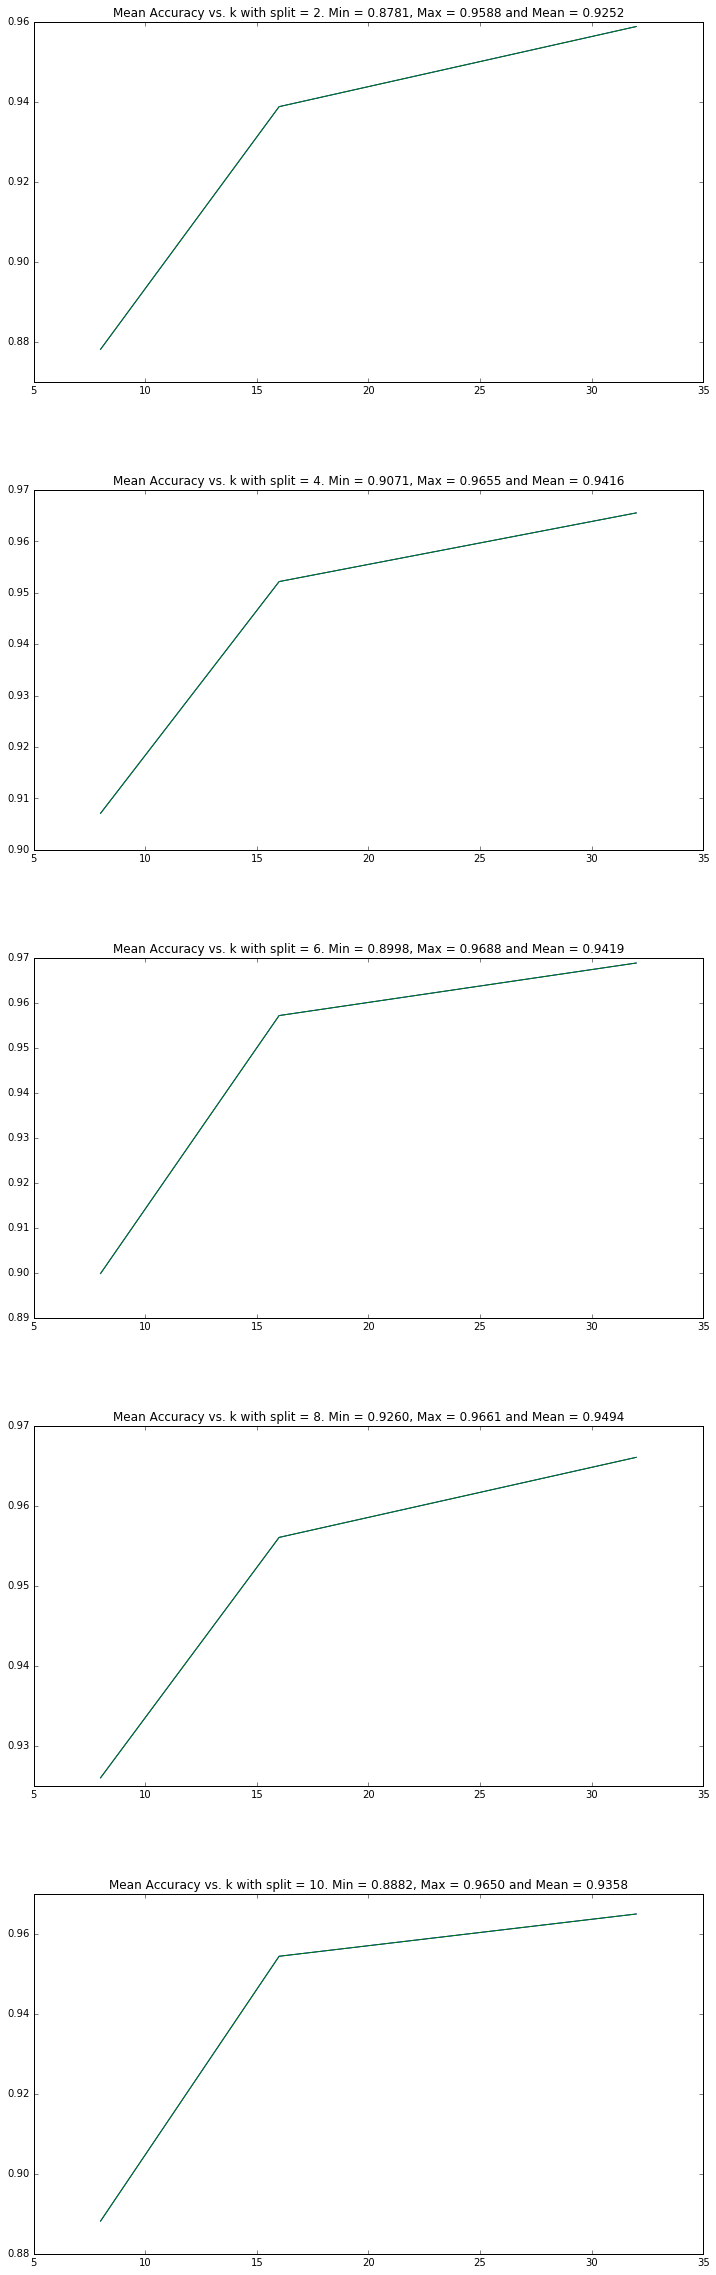

In [16]:
overall_accuracies, best_worst, accuracy_dict = validate_and_plot_with_multiple_values(neuron_arches=nn_one_neurons,
                                                                                       k_splits=splits,
                                                                                       model_to_train="MLPClassifier")
best_worst.append(np.mean(overall_accuracies)*100)
key = "MLPClassifier with neurons = {} \nand splits = {}".format(
    nn_one_neurons, splits)
summary[key] = best_worst


In [17]:
print("mean accuracy = {:0.6f}%".format(best_worst[-1]))

mean accuracy = 93.879392%


## Neural Network with three hidden layers with neurons ranging from 8 to 128

In [18]:
nn_one_neurons = [(2**i, 2**i, 2**i) for i in range(3, 6)]
nn_one_neurons

[(8, 8, 8), (16, 16, 16), (32, 32, 32)]


################################################################################
testing `MLPClassifier` with nueron values = [(8, 8, 8), (16, 16, 16), (32, 32, 32)] and splits = [2, 4, 6, 8, 10]...


/dataquest/system/env/python3/lib/python3.4/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.



worst accuracy is 0.8748 acheived at split = 10 and neurons = (8, 8, 8)
best accuracy is 0.9694 acheived at split = 8 and neurons = (32, 32, 32)


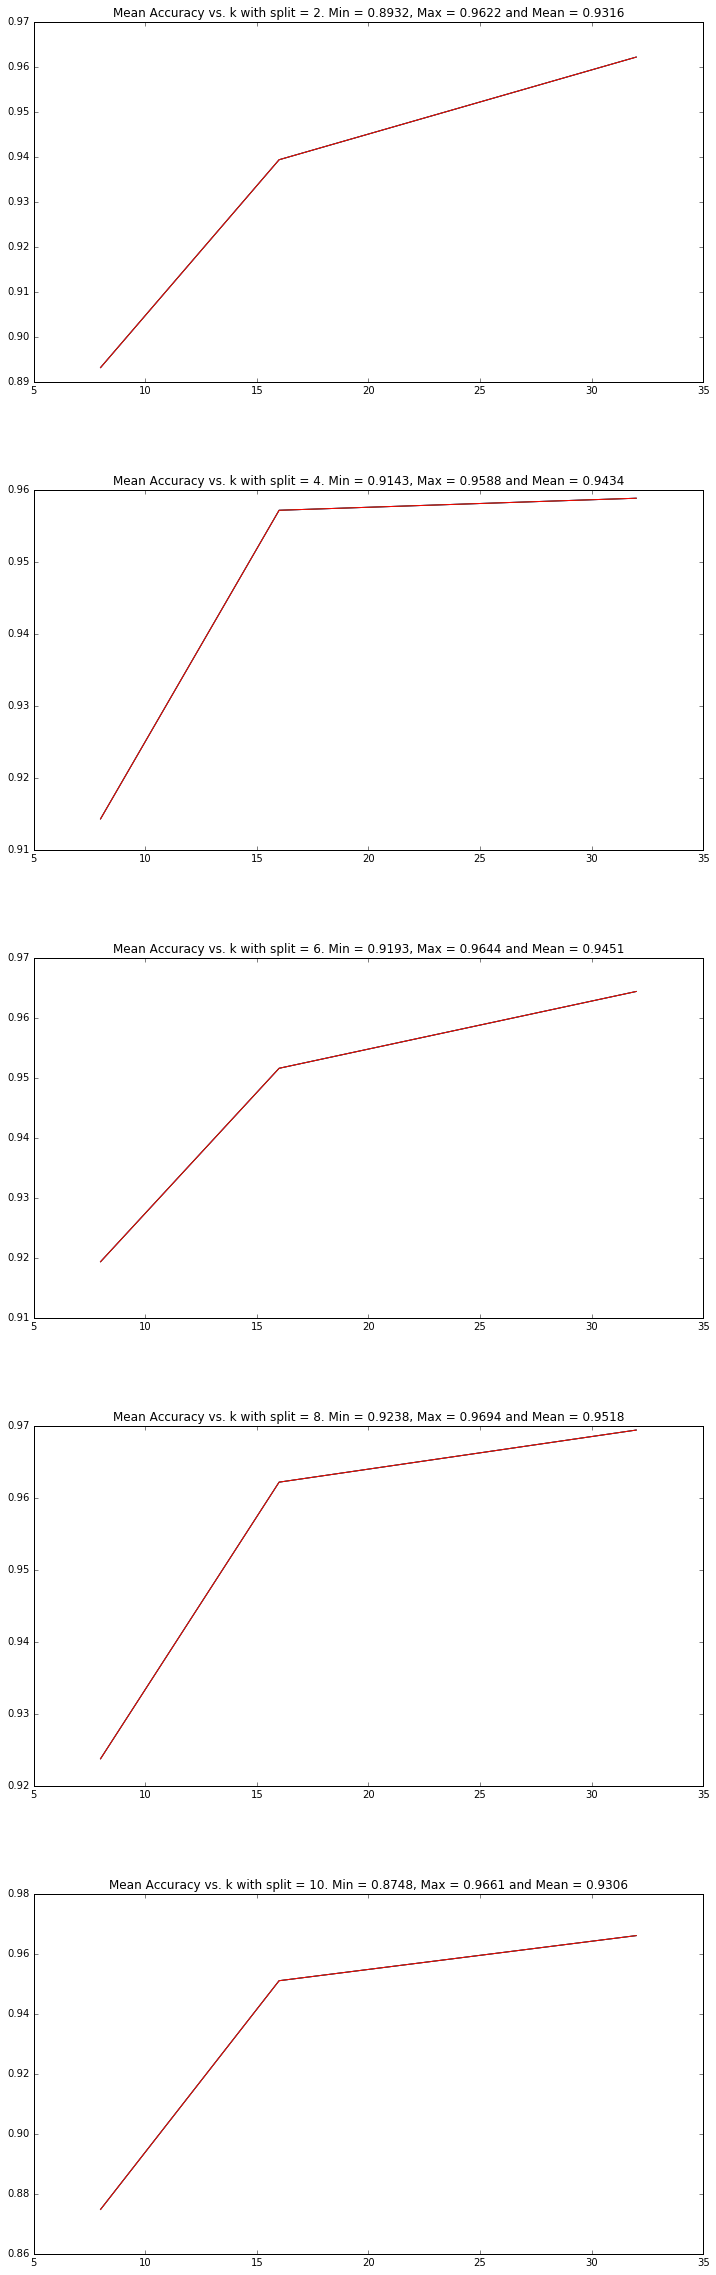

In [19]:
overall_accuracies, best_worst, accuracy_dict = validate_and_plot_with_multiple_values(neuron_arches=nn_one_neurons,
                                                                                       k_splits=splits,
                                                                                       model_to_train="MLPClassifier")
best_worst.append(np.mean(overall_accuracies)*100)
key = "MLPClassifier with neurons = {} \nand splits = {}".format(
    nn_one_neurons, splits)
summary[key] = best_worst

In [20]:
print("mean accuracy = {:0.6f}%".format(best_worst[-1]))

mean accuracy = 94.049794%


In [27]:
nn_one_neurons = [(2**i, 2**i, 2**i) for i in range(3, 9)]
nn_one_neurons

[(8, 8, 8),
 (16, 16, 16),
 (32, 32, 32),
 (64, 64, 64),
 (128, 128, 128),
 (256, 256, 256)]


################################################################################
testing `MLPClassifier` with nueron values = [(8, 8, 8), (16, 16, 16), (32, 32, 32), (64, 64, 64), (128, 128, 128), (256, 256, 256)] and splits = [2, 4, 6, 8, 10]...


/dataquest/system/env/python3/lib/python3.4/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.



worst accuracy is 0.8753 acheived at split = 2 and neurons = (8, 8, 8)
best accuracy is 0.9816 acheived at split = 8 and neurons = (256, 256, 256)


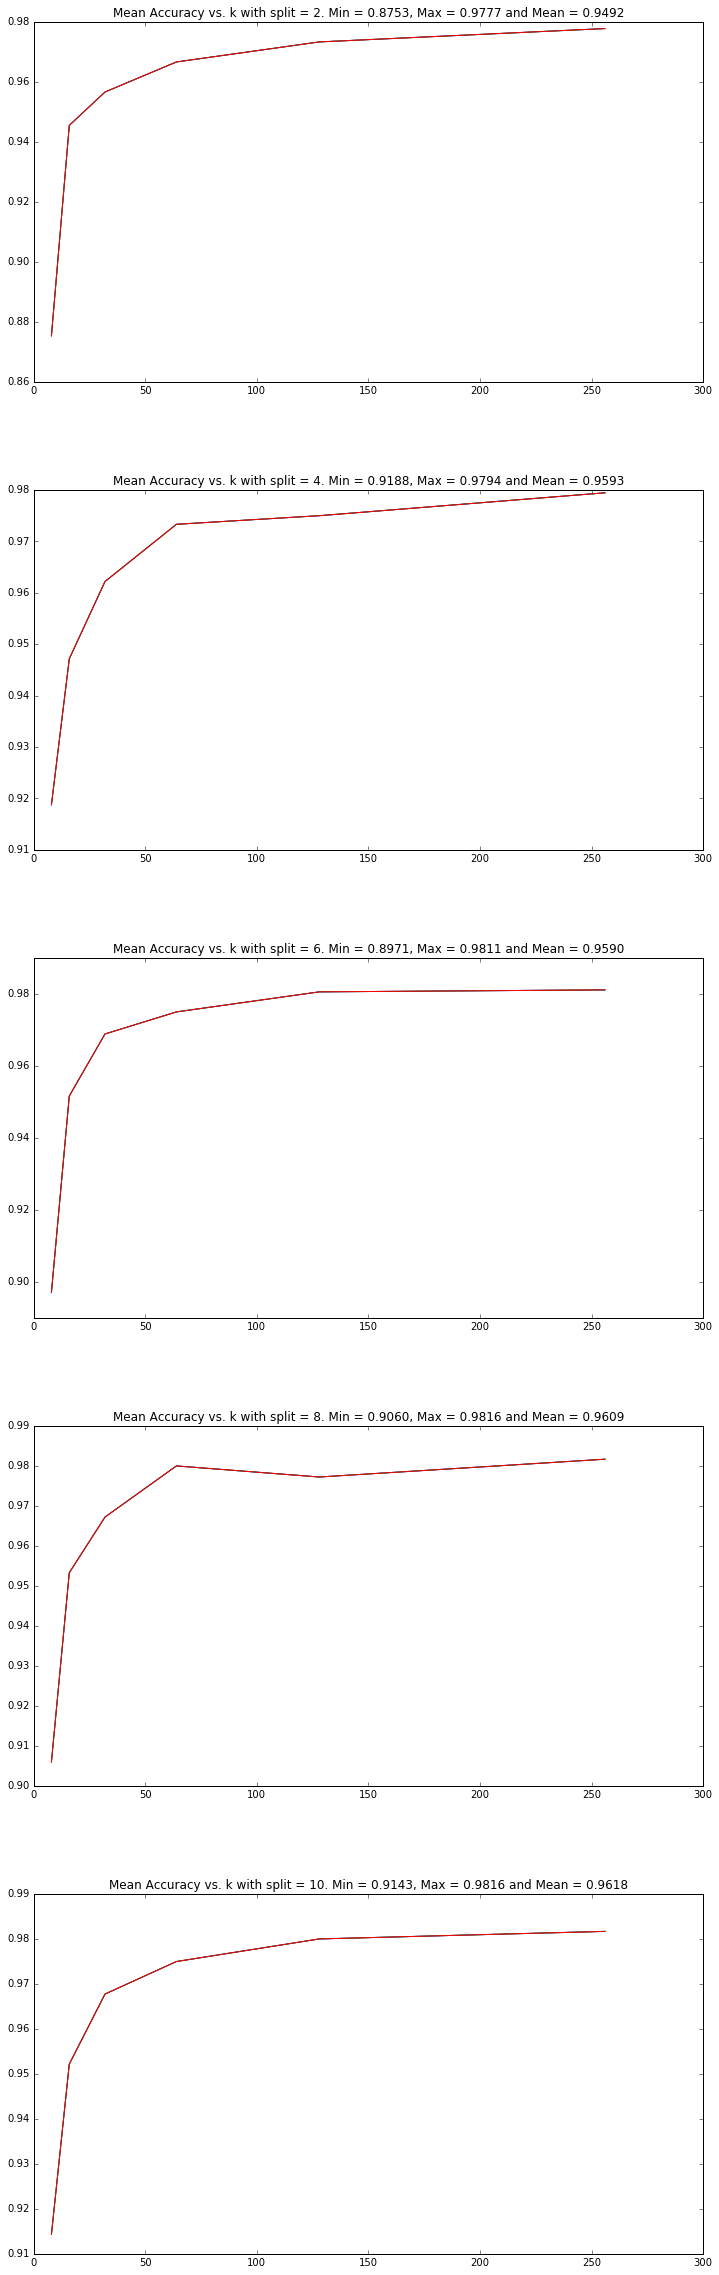

In [28]:
overall_accuracies, best_worst, accuracy_dict = validate_and_plot_with_multiple_values(neuron_arches=nn_one_neurons,
                                                                                       k_splits=splits,
                                                                                       model_to_train="MLPClassifier")
best_worst.append(np.mean(overall_accuracies)*100)
key = "MLPClassifier with neurons = {} \nand splits = {}".format(
    nn_one_neurons, splits)
summary[key] = best_worst

In [29]:
summary_df = build_summary(summary)
sorted_summary_df = summary_df.sort_values(by='mean accuracy', ascending=False)
sorted_summary_df

,model,worst_accuracy_at,worst_accuracy,best_accuracy_at,best_accuracy_at,mean accuracy
1,"KNeighborsClassifier with k = [1, 2, 3, 4, 5, ...",split = 4 and k = 8,0.980527,split = 4 and k = 1,0.988873,98.411202
3,"KNeighborsClassifier with k = [1, 2, 3, 4, 5, ...",split = 2 and k = 9,0.971065,split = 4 and k = 1,0.988873,98.277380
5,"MLPClassifier with neurons = [(8, 8, 8), (16, ...","split = 2 and neurons = (8, 8, 8)",0.875333,"split = 8 and neurons = (256, 256, 256)",0.981649,95.802946
2,"MLPClassifier with neurons = [(8, 8, 8), (16, ...","split = 10 and neurons = (8, 8, 8)",0.874783,"split = 8 and neurons = (32, 32, 32)",0.969410,94.049794
0,"MLPClassifier with neurons = [(8, 8), (16, 16)...","split = 2 and neurons = (8, 8)",0.878114,"split = 6 and neurons = (32, 32)",0.968839,93.879392
4,"MLPClassifier with neurons = [(8,), (16,), (32...","split = 4 and neurons = (8,)",0.857598,"split = 10 and neurons = (32,)",0.966055,93.322915


# Summary

Using 3 hidden layers improved our simple accuracy to 98%, even with 6-fold cross validation. The KNN model seems to outperform the neural network when the neurons are less (around 32). The overall accuracy of nn increases as we add more neurons in each layers. Although multiple rounds seems to be indicate the MLP with higher number of neurons like 